In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [3]:
# Define a function for tokenization (splitting by '/' and removing any ';')
def custom_tokenizer(text):
    return text.replace(';', '').split('/')

# Load dataset from train.csv
df = pd.read_csv('train.csv')
df.head(10)

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male
5,u20964,12/12/14 15:31,12/12/14 15:31,A00002/B00002/C00081/D25039/,female
6,u20981,05/12/14 19:33,05/12/14 19:34,A00002/B00011/C00180/D18487/;A00002/B00011/C00...,female
7,u15947,09/12/14 16:02,09/12/14 16:06,A00002/B00001/C00059/D15254/;A00002/B00001/C00...,male
8,u18193,25/11/14 11:55,25/11/14 11:55,A00002/B00001/C00010/D06129/,male
9,u21820,06/12/14 16:16,06/12/14 16:17,A00002/B00001/C00010/D12841/;A00002/B00002/C00...,female


In [7]:

df_sample = df.sample(frac=1.0, random_state=42)

# Convert ProductList to a bag-of-words representation using the custom tokenizer
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, binary=True)
product_features = vectorizer.fit_transform(df_sample['ProductList'])

c:\Users\imvin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
# Calculate session duration in seconds
df_sample['startTime'] = pd.to_datetime(df_sample['startTime'], format='%d/%m/%y %H:%M')
df_sample['endTime'] = pd.to_datetime(df_sample['endTime'], format='%d/%m/%y %H:%M')
df_sample['session_duration'] = (df_sample['endTime'] - df_sample['startTime']).dt.total_seconds()


In [9]:
# Concatenate product features with session duration
X = np.hstack([product_features.toarray(), df_sample['session_duration'].values.reshape(-1, 1)])

# Encode the target variable (gender)
encoder = LabelEncoder()
y = encoder.fit_transform(df_sample['gender'])

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:

model = SVC(kernel='linear', C=1.0, random_state=42)
model.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [8]:
# Save the trained model and vectorizer to disk
joblib.dump(model, 'svm_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(encoder, 'label_encoder.pkl')

print("Model and preprocessing components saved successfully ")

Model and preprocessing components saved successfully 


In [13]:
# Load the saved model and preprocessing components (for future use)
loaded_model = joblib.load('svm_model.pkl')
loaded_vectorizer = joblib.load('vectorizer.pkl')
loaded_encoder = joblib.load('label_encoder.pkl')

# Make predictions with the loaded model
y_pred = loaded_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=loaded_encoder.classes_))


Accuracy: 0.8442857142857143
Classification Report:
               precision    recall  f1-score   support

      female       0.88      0.93      0.90      1644
        male       0.67      0.55      0.60       456

    accuracy                           0.84      2100
   macro avg       0.78      0.74      0.75      2100
weighted avg       0.84      0.84      0.84      2100



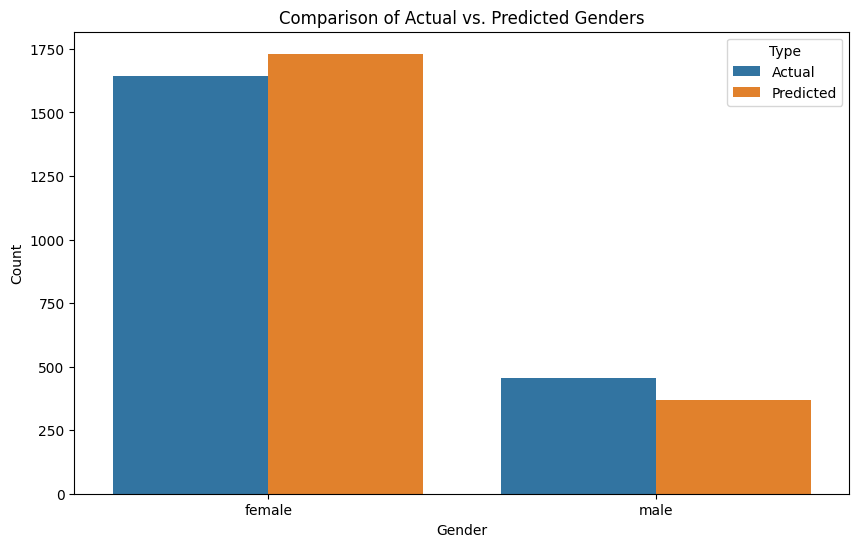

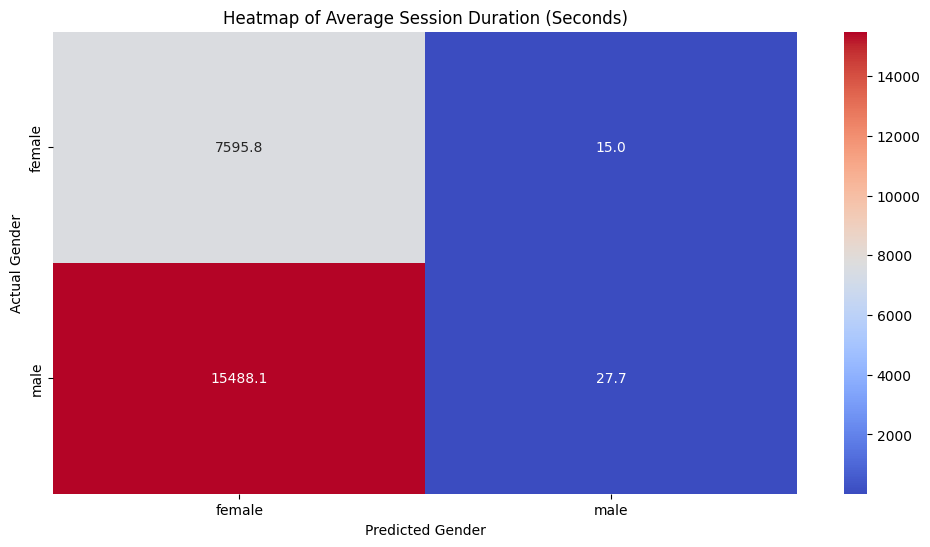

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot Predicted vs Actual Values
actual_labels = loaded_encoder.inverse_transform(y_test)
predicted_labels = loaded_encoder.inverse_transform(y_pred)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({'Actual': actual_labels, 'Predicted': predicted_labels})

# Plot a bar chart of actual vs. predicted counts
plt.figure(figsize=(10, 6))
sns.countplot(data=comparison_df.melt(), x='value', hue='variable')
plt.title('Comparison of Actual vs. Predicted Genders')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Type')
plt.show()

# Heatmap for Session Duration vs. Actual and Predicted
heatmap_df = pd.DataFrame({
    'Session Duration': X_test[:, -1],
    'Actual': actual_labels,
    'Predicted': predicted_labels
})

# heatmap showing session duration counts for actual vs. predicted values
plt.figure(figsize=(12, 6))
heatmap_data = pd.crosstab(heatmap_df['Actual'], heatmap_df['Predicted'], values=heatmap_df['Session Duration'], aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Heatmap of Average Session Duration (Seconds)')
plt.xlabel('Predicted Gender')
plt.ylabel('Actual Gender')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load the saved model and preprocessing components
loaded_model = joblib.load('svm_model.pkl')
loaded_vectorizer = joblib.load('vectorizer.pkl')
loaded_encoder = joblib.load('label_encoder.pkl')

# Load the test dataset for evaluating and analysing the performance
test_df = pd.read_csv('test.csv')

# Using only the first 10 rows / can use the complete dataset 
test_df = test_df.head(10)

# Define a custom tokenizer function (same as used during training)
def custom_tokenizer(text):
    return text.replace(';', '').split('/')

# Convert ProductList to a bag-of-words representation using the loaded vectorizer
product_features = loaded_vectorizer.transform(test_df['ProductList'])

# Calculate session duration in seconds
test_df['startTime'] = pd.to_datetime(test_df['startTime'], format='%d/%m/%y %H:%M')
test_df['endTime'] = pd.to_datetime(test_df['endTime'], format='%d/%m/%y %H:%M')
test_df['session_duration'] = (test_df['endTime'] - test_df['startTime']).dt.total_seconds()

# Concatenate product features with session duration
X_new = np.hstack([product_features.toarray(), test_df['session_duration'].values.reshape(-1, 1)])

# Make predictions
y_pred_numeric = loaded_model.predict(X_new)

# Convert numeric predictions back to original labels
y_pred_labels = loaded_encoder.inverse_transform(y_pred_numeric)

# Add predictions to the test DataFrame
test_df['Predicted Gender'] = y_pred_labels

# Display the first 10 rows with predicted genders
print(test_df[['session_id', 'Predicted Gender']])


  session_id Predicted Gender
0     u12112           female
1     u19725           female
2     u11795           female
3     u22639           female
4     u18034           female
5     u11327           female
6     u12768             male
7     u17011             male
8     u13527           female
9     u24492           female
